In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>Use linear regression to predict 'Yellow_improvement' if given 'voter_turn_percentage' because we will be using 'voter_turn_percentage' = 0.6 (60% voter turnout) for this question. 
    One outlier is removed to reduce the RMSE and improve R-squared of this linear regression.
<li>Take average Purple expected vote share from each district, and subtract each average by the predicted 'Yellow_improvement' value. Use this new average as the mean vote share when running simulation.
<li>Do a normality test to find p-value of data for each district. Districts 1, 3, 6, and 7 have a p-value >0.05, so it is a normal distribution, but districts 2, 4, and 5 have a p-value < 0.05. Since 4/7 districts appear to be distributed normally, I will just assume the polls all follow a normal distribution. Not the best assumption, but it gets too complicated if population isn't normally distributed when running the simulation. 
<li>Simulate the election 1000 times, each time count the total number of districts Purple wins, add this number into a list, then count the numbers in this list that are >= 4 (which means Purple won).
<li> <b> What do you think about the error/accuracy:</b> In order to achieve a R-squared of 0.8, one outlier had to be remove, leaving a model using only 8 data points. More data points would improve accuracy and reduce error. Since data points is low, I decided to not remove any more outliers. Since the election is simulated 1000 times with 95% confidence intervals, the accuracy of the prediction should be okay. The average error of the polls across all districts is about 0.015 for n=1000. 
</ul>

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [2]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns={"district"})

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head()

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53


##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [3]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns={"voter_turn_percentage"})
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


## Start Your Work

### Part 1 - Election

In [4]:
#Functions for calculating RMSE and R2
def rmseFromResiduals(residuals):
    SSE = 0
    for i in range(len(residuals)):
        SSE += (residuals[i]**2)
    MSE = SSE/len(residuals)
    return math.sqrt(MSE)
def rSquared(yvals, residuals):
    return (1-(thinkstats2.Var(residuals)/thinkstats2.Var(yvals)))

Y-intercept: -0.19374537987679685
Slope: 0.3858316221765916
RMSE: 0.018967303783676472
R2: 0.33225372047195945


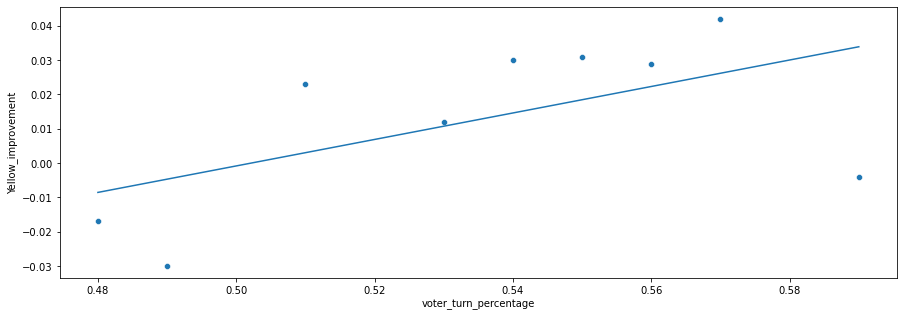

In [5]:
#Linear regression for 'voter_turn_percentage' vs. 'Yellow_improvement
inter, slope = thinkstats2.LeastSquares(past_vote_table['voter_turn_percentage'], past_vote_table['Yellow_improvement'])
res = thinkstats2.Residuals(past_vote_table['voter_turn_percentage'], past_vote_table['Yellow_improvement'], inter, slope)
regLine = thinkstats2.FitLine(past_vote_table['voter_turn_percentage'], inter, slope)
sns.scatterplot(data=past_vote_table, x=past_vote_table['voter_turn_percentage'], y=past_vote_table['Yellow_improvement'])
sns.lineplot(x=regLine[0], y=regLine[1])

print('Y-intercept:', inter)
print('Slope:', slope)
print('RMSE:', rmseFromResiduals(res))
print('R2:', rSquared(past_vote_table['Yellow_improvement'], res))

Based on the figure above, it looks like the point at 'voter_turn_precentage' = 0.59 is an outlier. The R-squared of the fit line being 0.33 is quite low, so I've decided to remove this outlier. 

Y-intercept: -0.35291819699499155
Slope: 0.6958263772954922
RMSE: 0.010622761966000668
R2: 0.800630615218533


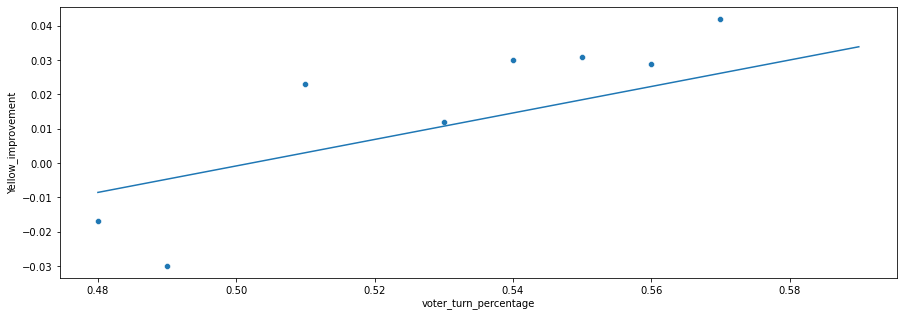

In [6]:
#Remove outlier. Redo linear regression.
past_vote_table_remove_outlier = past_vote_table[past_vote_table['voter_turn_percentage']<0.58]

#Do linear regression again, but without the outlier. 
inter2, slope2 = thinkstats2.LeastSquares(past_vote_table_remove_outlier['voter_turn_percentage'], past_vote_table_remove_outlier['Yellow_improvement'])
res2 = thinkstats2.Residuals(past_vote_table_remove_outlier['voter_turn_percentage'], past_vote_table_remove_outlier['Yellow_improvement'], inter2, slope2)
regLine2 = thinkstats2.FitLine(past_vote_table_remove_outlier['voter_turn_percentage'], inter2, slope2)
sns.scatterplot(data=past_vote_table_remove_outlier, x=past_vote_table_remove_outlier['voter_turn_percentage'], y=past_vote_table_remove_outlier['Yellow_improvement'])
sns.lineplot(x=regLine[0], y=regLine[1])

print('Y-intercept:', inter2)
print('Slope:', slope2)
print('RMSE:', rmseFromResiduals(res2))
print('R2:', rSquared(past_vote_table_remove_outlier['Yellow_improvement'], res2))

R-squared is 0.80 now, and RMSE improved too. Could probably be improved furthur, but since I only started with 9 data points, I don't want to remove any more data points as that might reduce the accuracy of the linear regression too much. So I'll use this to predict 'Yellow_improvement'.

In [28]:
#Seperate each district, remove district column, use distribution plot for each district. 
district1 = dist_polls[dist_polls['district'] == 1].drop(columns='district')
district2 = dist_polls[dist_polls['district'] == 2].drop(columns='district')
district3 = dist_polls[dist_polls['district'] == 3].drop(columns='district')
district4 = dist_polls[dist_polls['district'] == 4].drop(columns='district')
district5 = dist_polls[dist_polls['district'] == 5].drop(columns='district')
district6 = dist_polls[dist_polls['district'] == 6].drop(columns='district')
district7 = dist_polls[dist_polls['district'] == 7].drop(columns='district')

district1['Average_Poll'] = district1.mean(axis=1)
district2['Average_Poll'] = district2.mean(axis=1)
district3['Average_Poll'] = district3.mean(axis=1)
district4['Average_Poll'] = district4.mean(axis=1)
district5['Average_Poll'] = district5.mean(axis=1)
district6['Average_Poll'] = district6.mean(axis=1)
district7['Average_Poll'] = district7.mean(axis=1)



In [77]:
#Hypothesis test for normality on each district
import scipy.stats
p1 = scipy.stats.normaltest(district1.transpose())
p2 = scipy.stats.normaltest(district2.transpose())
p3 = scipy.stats.normaltest(district3.transpose())
p4 = scipy.stats.normaltest(district4.transpose())
p5 = scipy.stats.normaltest(district5.transpose())
p6 = scipy.stats.normaltest(district6.transpose())
p7 = scipy.stats.normaltest(district7.transpose())

p1, p2, p3, p4, p5, p6, p7

c:\Users\billg\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


(NormaltestResult(statistic=array([1.71060211]), pvalue=array([0.42515518])),
 NormaltestResult(statistic=array([9.30537703]), pvalue=array([0.00953593])),
 NormaltestResult(statistic=array([1.59542833]), pvalue=array([0.45035723])),
 NormaltestResult(statistic=array([10.22298548]), pvalue=array([0.00602708])),
 NormaltestResult(statistic=array([7.33300568]), pvalue=array([0.02556572])),
 NormaltestResult(statistic=array([0.30556775]), pvalue=array([0.85831521])),
 NormaltestResult(statistic=array([0.8367955]), pvalue=array([0.65810042])))

Districts 1, 3, 6, 7 have p-value > 0.05, but districts 2, 5, 6 have p-value < 0.05. 4/7 districts are normally distributed so I will just assume the population is normally distributed for the sake of the simulation. 

In [84]:
#Functions used to simulate votes in the simulation. 
def oneVote(probCalc):
    vote = np.random.binomial(n=1, p=probCalc)
    return vote

def getSample(voteProb, n=1000):
    vote_list = []
    for i in range(n):
        vote_list.append(oneVote(voteProb))
    return vote_list

def getSamples(voteProb, n=1000, samples=100, ciLow=2.5, ciHi=97.5):
    meanList = []
    for i in range(samples):
        meanList.append(np.mean(getSample(voteProb, n)))
    muList = [voteProb] * samples
    cdf = thinkstats2.Cdf(meanList)
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    stderr = mean_squared_error(meanList, muList, squared=False)
    return meanList, stderr, cdf, ci

0.607

In [10]:
#This code simulates the election 1000 times.
#This code takes a while to run because the loops runs 1000 times. Could probably be optimized but I'm not sure how. Anyways it works just a bit slow (about 2-3 minutes to execute on my computer).

yellow_improvement_60_percent_turnout = slope2*0.6+inter2 #Calculate yellow improvement factor.

totallist=[] #List of number of districts purple wins, each element in this list represents 1 simulation. 

for x in range(1000): #Repeat this simulation 1000 times.
    trials = 1 #Simulate each district one time. 
    means1, err1, cdfFin1, ciFin1 = getSamples(district1['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means2, err2, cdfFin2, ciFin2 = getSamples(district2['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means3, err3, cdfFin3, ciFin3 = getSamples(district3['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means4, err4, cdfFin4, ciFin4 = getSamples(district4['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means5, err5, cdfFin5, ciFin5 = getSamples(district5['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means6, err6, cdfFin6, ciFin6 = getSamples(district6['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    means7, err7, cdfFin7, ciFin7 = getSamples(district7['Average_Poll']-yellow_improvement_60_percent_turnout, n=700, samples=trials)
    pWins1 = 0 
    pWins2 = 0 
    pWins3 = 0 
    pWins4 = 0 
    pWins5 = 0 
    pWins6 = 0 
    pWins7 = 0 
    for i in range(len(means1)):
        if means1[i] > .5000:
            pWins1 = pWins1 + 1
    for i in range(len(means2)):
        if means2[i] > .5000:
            pWins2 = pWins2 + 1
    for i in range(len(means3)):
        if means3[i] > .5000:
            pWins3 = pWins3 + 1        
    for i in range(len(means4)):
        if means4[i] > .5000:
            pWins4 = pWins4 + 1
    for i in range(len(means5)):
        if means5[i] > .5000:
            pWins5 = pWins5 + 1
    for i in range(len(means6)):
        if means6[i] > .5000:
            pWins6 = pWins6 + 1
    for i in range(len(means7)):
        if means7[i] > .5000:
            pWins7 = pWins7 + 1
    total = pWins1+pWins2+pWins3+pWins4+pWins5+pWins6+pWins7 #Calculate the total number of districts purple wins in 1 simulation, this works because I set trials = 1 in the loop. The value of this 'total' variable cannot logically exceed 7 in each loop. 
    totallist.append(total) #Add the 'total' value to a list.

purple_election_wins = sum(i>=4 for i in totallist) #Count the number of elements in the list 'totallist' which are >= 4. This can be interpreted as the number of times Purple won the election. 
print('In 1000 simulations, the number of times Purple wins 4 or more districts is:', purple_election_wins)


0

In [27]:
max(totallist) #Show the maximum districts Purple won in any trial of the 1000 trials

3

In [98]:
#Check error for polls of each district. 
countHist = 1
nVals = [1000]
samples = 100
for i in range(countHist):
    tmpH1, err1, cdf1, ci1 = getSamples(district1['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 1:", err1)
for i in range(countHist):
    tmpH2, err2, cdf2, ci2 = getSamples(district2['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 2:", err2)
for i in range(countHist):
    tmpH3, err3, cdf3, ci3 = getSamples(district3['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 3:", err3)
for i in range(countHist):
    tmpH4, err4, cdf4, ci4 = getSamples(district4['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 4:", err4)
for i in range(countHist):
    tmpH5, err5, cdf5, ci5 = getSamples(district5['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 5:", err5)
for i in range(countHist):
    tmpH6, err6, cdf6, ci6 = getSamples(district6['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 6:", err6)
for i in range(countHist):
    tmpH7, err7, cdf7, ci7 = getSamples(district7['Average_Poll']-yellow_improvement_60_percent_turnout, nVals[i], samples)
    print("Error in district 7:", err7)
print('Average error across all districts:', (err1+err2+err3+err4+err5+err6+err7)/7)

Error in district 1: 0.01603349893474949
Error in district 2: 0.014906529699888406
Error in district 3: 0.014690696962336196
Error in district 4: 0.01621610889266082
Error in district 5: 0.014136946686992771
Error in district 6: 0.014692064302160503
Error in district 7: 0.014130767373187185
Average error across all districts: 0.01497237326456791


Conclusion: 

Based on the simulation above, in 1000 simulations, Purple wins a total of 0 times. I've repeated this simulation a few times and Purple has never won a single election in 1000 simulations. Out of curiousity I used max(totallist) to find the maximum number of districts Purple won in any simluation trial, and the most I've seen is 3, which is just on the edge of not enough districts to win the election. 

### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>Remove wage = 0 as outlier, no other noticable outliers that can be removed. 
<li>Convert data into 2 arrays, one for target (wage), and one for the predictive features.
<li>Generate the model and obtain the RMSE, R-squared, Y-intercept, and Coefficients for the model.
<li>I tried removing some features and outliers to see if RMSE or R-squred of model improved, but whatever I do RMSE or R-squared doesn't improve much. 
</ul>

In [11]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


In [12]:
df.describe()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,...,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,9456.942773,49.718405,45.590218,52.221468,58.748003,42.809388,55.596509,47.325692,42.708885,52.768848,...,46.812945,55.742149,46.380239,50.072163,53.609749,48.383357,58.528778,46.848889,47.640333,45.606631
std,21351.714095,18.325403,19.594609,17.428429,14.679653,17.701815,18.929118,18.422991,17.433612,15.246454,...,19.322343,17.318157,20.775812,19.594022,13.955626,15.708099,11.880840,20.091287,21.585641,21.217734
min,0.000000,5.000000,2.000000,5.000000,7.000000,3.000000,4.000000,6.000000,4.000000,8.000000,...,4.000000,9.000000,3.000000,2.000000,9.000000,7.000000,12.000000,1.000000,5.000000,3.000000
25%,1000.000000,38.000000,30.000000,44.000000,54.000000,30.000000,50.000000,34.000000,31.000000,43.000000,...,32.000000,44.000000,25.000000,39.000000,44.000000,39.000000,51.000000,29.000000,27.000000,24.000000
50%,3000.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,49.000000,41.000000,56.000000,...,51.000000,58.000000,52.000000,55.000000,55.000000,49.000000,60.000000,52.000000,55.000000,52.000000
75%,8000.000000,64.000000,62.000000,64.000000,68.000000,56.000000,68.000000,62.000000,56.000000,64.000000,...,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000
max,565000.000000,93.000000,95.000000,93.000000,92.000000,90.000000,97.000000,94.000000,94.000000,92.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,92.000000,90.000000


In [111]:
#Remove outlier
df=df[df['wage_eur']>0]


In [120]:
#Convert target feature into y-array and prediction features into x-array. 
y = np.array(df["wage_eur"]).reshape(-1,1)
y.shape
df_ = df.drop(columns=["wage_eur"]).drop(columns=["power_long_shots"]).drop(columns=["mentality_penalties"]).drop(columns=["defending_standing_tackle"])
df_.head()
x = np.array(df_)
x.shape

#Split and train
xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=.3)

#Generate model
model = LinearRegression().fit(xTrain,yTrain)

#Get RMSE and R-squared
r_sq = model.score(xTest, yTest)
print('R-squared:', r_sq)

tmp = model.predict(xTest)
print('RMSE:', mean_squared_error(tmp, yTest, squared=False))

#Get Y-intercept and Coefficients
print('Intercept:', model.intercept_[0])
print('Coefs:', model.coef_[0])


R-squared: 0.2715485552663355
RMSE: 20332.858626003923
Intercept: -61437.03420865572
Coefs: [  10.84976914  -23.20678146  -36.79170241  106.37872043   80.01977752
   -1.50892419   12.68537252  -65.86816805  -27.80179918   72.20408592
   13.79780741   97.54443747 -108.58310771  907.64436394  -59.2183996
   92.40626263   51.79820523 -113.50029632  -47.83806914  -55.20392406
    4.96019568 -109.31804015  103.83144024  230.01480987   -5.87908352
   38.91747576]


Conclusion:
Tried dropping several features, but RMSE is always around 20000 and R-squared around 0.30. So in conclusion the features are not that good at predicting wage. 